# Climate Analysis

In [ ]:
# Import dependencies

import pandas as pd
import numpy as np

from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc
from sqlalchemy import Column, Integer, String, Float, ForeignKey,func
from sqlalchemy.sql import label
from sqlalchemy import and_

from flask import Flask, jsonify

import matplotlib.pyplot as plt
import datetime as dt

import seaborn as sns
import random
import os

In [4]:
# Connect to sqlite database
engine = create_engine("sqlite:///hawaii.sqlite")
conn = engine.connect()

In [5]:
# Reflect tables into classes
Base = automap_base()
Base.prepare(engine, reflect=True)

# Print all classes mapped to the Base
Base.classes.keys()

['measurement',
 'measurements',
 'st',
 'stan',
 'stat',
 'station',
 'station_house',
 'stations',
 'stations_nu',
 'stn']

In [6]:
Measurements = Base.classes.measurements
Stations = Base.classes.stations

In [7]:
session = Session(bind = engine)

In [8]:
# Get table names for each table
inspector = inspect(engine)
inspector.get_table_names()

['measurement',
 'measurements',
 'st',
 'stan',
 'stat',
 'station',
 'station_house',
 'stations',
 'stations_nu',
 'stn']

In [9]:
# Query for 12 months of data and set index
dates = session.query(Measurements.date, Measurements.prcp).filter(and_(
    Measurements.date <= '2017-12-01', Measurements.date >= '2016-12-01')).all()
dates_df = pd.DataFrame(dates)
dates_df.set_index("date", inplace = True)
dates_df = dates_df.rename(columns={'prcp': 'precipitation'})

dates_df.head(10)

,precipitation
date,
2016-12-01,0.12
2016-12-02,0.03
2016-12-03,0.00
2016-12-04,0.03
2016-12-05,0.43
2016-12-06,0.02
2016-12-07,0.00
2016-12-08,0.03
2016-12-09,0.52


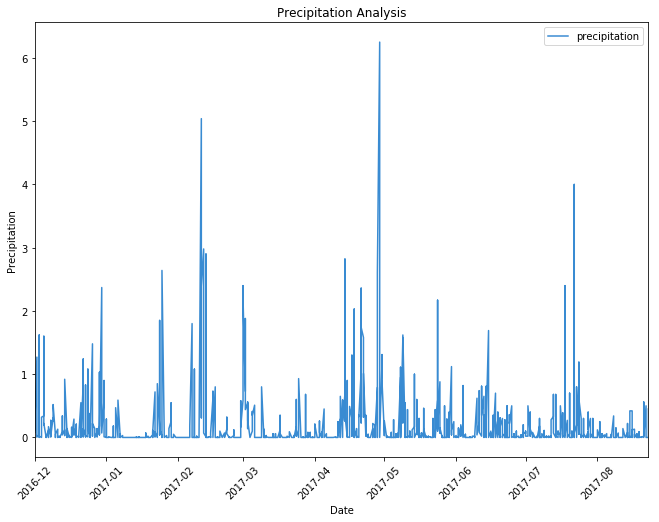

In [21]:
dates_df.plot(figsize = (11,8), rot = 45, color="#398bd2")
plt.ylabel('Precipitation')
plt.xlabel('Date')
plt.title('Precipitation Analysis')
plt.show()

In [15]:
# Summary Statistics
dates_df.describe()

,precipitation
count,1445.000000
mean,0.170062
std,0.441790
min,0.000000
25%,0.000000
50%,0.010000
75%,0.120000
max,6.250000


In [ ]:
# Station Analysis

In [22]:
# Number of Stations and station actvity
number_stations = session.query(Stations.station).group_by(Stations.station).count()
number_stations

9

In [11]:
active_stations = session.query(Stations.name, Measurements.station, func.count(Measurements.tobs)).filter(Stations.station == Measurements.station).group_by(Measurements.station).order_by(func.count(Measurements.tobs).desc()).all()
active_stations

[('WAIHEE 837.5, HI US', 'USC00519281', 2772),
 ('KANEOHE 838.1, HI US', 'USC00513117', 2696),
 ('WAIKIKI 717.2, HI US', 'USC00519397', 2685),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2572),
 ('MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2484),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 1937),
 ('HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1932),
 ('PEARL CITY, HI US', 'USC00517948', 683),
 ('UPPER WAHIAWA 874.3, HI US', 'USC00518838', 342)]

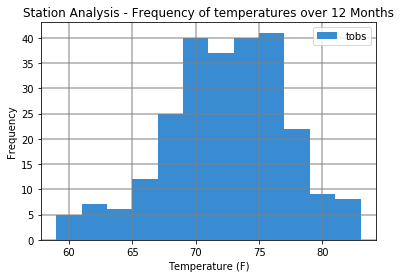

In [23]:
most_high = "USC00519281"
most_active = session.query(Measurements.tobs).filter(Measurements.date >= "2016-12-01").filter(Measurements.station == most_high).all()

most_active_df = pd.DataFrame(most_active)

plt.figure(figsize=(12,10))
most_active_df.plot.hist(bins=12,color="#398bd2")

# most_active_df.plot.hist(bins=12,color="#398bd2")
plt.grid(color='grey', linestyle='-', linewidth=2, alpha=0.5)
plt.ylabel("Frequency")
plt.xlabel("Temperature (F)")
plt.title("Station Analysis - Frequency of temperatures over 12 Months")
plt.show()


In [21]:
# Temperature Analysis

In [22]:
# Choose start and end dates for trip

In [28]:
# sd - start date / ed - end date 
def calc_temps(sd, ed):
    
    max_temp = session.query(func.max(Measurements.tobs)).filter(Measurements.date <= ed).filter(Measurements.date >= sd).scalar()
    avg_temp = session.query(func.avg(Measurements.tobs)).filter(Measurements.date <= ed).filter(Measurements.date >= sd).scalar()
    min_temp = session.query(func.min(Measurements.tobs)).filter(Measurements.date <= ed).filter(Measurements.date >= sd).scalar()
    
    return {'max_temp': max_temp,'avg_temp': avg_temp, 'min_temp': min_temp}
                       

In [84]:
start_date = datetime.datetime.strptime(input('Enter Start date in the format y-m-d: '), '%Y-%m-%d')
end_date = datetime.datetime.strptime(input('Enter End date in the format y-m-d: '), '%Y-%m-%d')
print(start_date, " ", end_date)

Enter Start date in the format y-m-d: 2016-12-01
Enter End date in the format y-m-d: 2017-12-01
2016-12-01 00:00:00   2017-12-01 00:00:00


In [85]:
temp_stats = calc_temps(start_date, end_date)
temp_stats

{'avg_temp': 73.67060458651842, 'max_temp': 87.0, 'min_temp': 58.0}

In [ ]:
# Climate App - create a bar plot

In [86]:
plt.figure(figsize=(2,5))
plt.bar(1, width = .1, height = temp_stats['avg_temp'], yerr = int(temp_stats['max_temp'])-int(temp_stats['min_temp']),color="#efbaa1")
plt.ylabel('Temp(F)')
plt.title('Trip Average Temperature')

Text(0.5,1,'Trip Average Temperature')

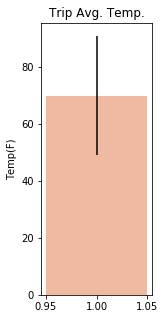

In [41]:
plt.show()

In [ ]:
# Climate App - Flask API

In [96]:
#Start Flask application
from flask import Flask, jsonify
app = Flask(__name__)

In [99]:
@app.route("/")
def Welcome():
    return(
        f"Available routes!</br>"
        f"/api.v1.0/precipitation</br>"
        f"/api/v1.0/stations</br>"
        f"/api/v1.0/tobs</br>"
        f"/api/v1.0/<start><br>"
        f"/api/v1.0/<start>/<end>"
     )

if __name__ == '__main__':
    app.run(debug=True)
    

 * Restarting with stat


SystemExit: 1

C:\Users\PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [100]:
# Return precipitation information of previous year

@app.route("/api.v1.0/precipitation")
def precip():
    
    query = session.query(Measurement.date, func.sum(Measurement.prcp).label("prcp")). \
    group_by(Measurement.date).order_by(Measurement.id.desc()).limit(365).all()

    precipitation = []
    for rain_drop in query:
        drop_top = {}
        drop_top["Date"] = rain_drop.date
        drop_top["Total Precip"] = rain_drop.prcp
        precipitation.append(drop_top)

    return jsonify(precipitation)

if __name__ == '__main__':
    app.run(debug=True)

 * Restarting with stat


SystemExit: 1

C:\Users\PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [79]:
# Return stations information

@app.route("/api/v1.0/stations")
def stations():

    stat = session.query(Station).all()
    
    station_info = []
    for looping in stat:
        blank_dict = {}
        blank_dict["Station"] = looping.station
        blank_dict["Name"] = looping.name
        blank_dict["Latitude"] = looping.latitude
        blank_dict["Longitude"] = looping.longitude
        blank_dict["Elevation"] = looping.elevation
        station_info.append(blank_dict)
    
    return jsonify(station_info)

if __name__ == '__main__':
    app.run(debug=True)

 * Restarting with stat


SystemExit: 1

C:\Users\PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [80]:
# Return Temperature information

@app.route("/api/v1.0/tobs")
def tobs():
    
    query = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.date >= "2016-01-01"). \
        filter(Measurement.date < "2017-01-01").all()
   
    Bring = []
    for hot in query:
        the_heat = {}
        the_heat["Station ID"] = hot.station
        the_heat["Date"] = hot.date
        the_heat["Temp Observed"] = hot.tobs
        Bring.append(the_heat)
    
    return jsonify(Bring)

if __name__ == '__main__':
    app.run(debug=True)

 * Restarting with stat


SystemExit: 1

C:\Users\PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [81]:
# Temperature from a start date

@app.route("/api/v1.0/<start>")
def temps(start='2016-01-01'):
    
    min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.date >= start).all()
    max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.date >= start).all()
    avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.date >= start).all()
    
    min_temp_str = str(min_temp[0][0])
    max_temp_str = str(max_temp[0][0])
    avg_temp_str = str(avg_temp[0][0])
    
    Temps = [{
            'Min Temp': min_temp_str,
            'Max Temp': max_temp_str,
            'Average Temp': avg_temp_str
    }]
    
    return jsonify(Temps)

if __name__ == '__main__':
    app.run(debug=True)

 * Restarting with stat


SystemExit: 1

C:\Users\PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [83]:
# Temperature from a date range

@app.route("/api/v1.0/<start>/<end>")
def temps_range(start='', end=''):
    
    min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.date >= start).\
            filter(Measurement.date <= end).all()
    max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.date >= start).\
            filter(Measurement.date <= end).all()
    avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.date >= start).\
            filter(Measurement.date <= end).all()
    
    min_temp_str = str(min_temp[0][0])
    max_temp_str = str(max_temp[0][0])
    avg_temp_str = str(avg_temp[0][0])
    
    Temps = [{
            'Min Temp': min_temp_str,
            'Max Temp': max_temp_str,
            'Average Temp': avg_temp_str
    }]
    
    return jsonify(Temps)

if __name__ == '__main__':
    app.run(debug=True)

 * Restarting with stat


SystemExit: 1

C:\Users\PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
